# TO DO

- Add back in the draws. 
- Figure out how to use non-numerical values classes maybe? 
- Modularize the code - put it into functions and that.

# Import data and access

In [1]:
from sklearn.preprocessing import StandardScaler
import kagglehub
import pandas as pd
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn as nn
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

torch.manual_seed(0)

In [2]:

# Download latest version
path = kagglehub.dataset_download("rajeevw/ufcdata")

print("Path to dataset files:", path)


names = ["\data.csv", "\preprocessed_data.csv", "\\raw_fighter_details.csv", "\\raw_total_fight_data.csv"]

data = []
data.append(pd.read_csv(path + names[0] ))
data.append(pd.read_csv(path + names[1] ))
data.append(pd.read_csv(path + names[2] ))
data.append(pd.read_csv(path + names[3] ))


Path to dataset files: C:\Users\joshe\.cache\kagglehub\datasets\rajeevw\ufcdata\versions\2


# Extract results for labels

In [3]:
def get_results(data):
    results = data.Winner

    results.replace("Red", 0, inplace = True)
    results.replace("Blue", 1, inplace = True)
    
    return results


# Get attributes and standardize

In [4]:
def get_attributes(data):
    attributes = data[data.columns.drop("Winner")]

    attributes.drop(columns = attributes.select_dtypes(exclude='number'), axis = 1, inplace=True)

    scaler = StandardScaler()
    attributes = pd.DataFrame(scaler.fit_transform(attributes), columns=attributes.columns)
    
    return attributes

# Organise the main data fram we are using

In [5]:
def Data_to_Useful(data):
    #Drop all draws
    #Can keep them and then have three categories to put them into
    data.drop(data[data["Winner"] == 'Draw'].index, inplace = True)

    #Look at other ways to deel with NA 
    #Replace them with the average perhaps?
    data.dropna(axis = 1, inplace = True)


    data.reset_index(drop=True, inplace = True)
    if 'index' in data.columns:
        data.drop(columns='index', inplace=True)
        
    results = get_results(data)
    attributes = get_attributes(data)
    
    return results, attributes


### Create dataset

In [6]:

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        # Return a dictionary with 'features' and 'label' as keys
        features = torch.tensor(self.x.iloc[index], dtype=torch.float32)
        label = torch.tensor(self.y[index], dtype=torch.long)
        return features, label
    
    def __len__(self):
        # Return the total number of samples
        return len(self.x)




# Class weighting

In [7]:
def class_weightings(train_dataset):
    train_classes = [label.item() for _, label in train_dataset]
    Counts = Counter(train_classes)

    total = Counts[0] + Counts[1]

    weight_0 = 100/Counts[0]
    weight_1 = 100/Counts[1]

    weightings = torch.Tensor([weight_1, weight_0])
    
    return weightings

def data_loaders(dataset):
    training_split = 0.9
    length = len(dataset)
    train_size = int(training_split * length)
    test_size = length - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    

    batch_size = 16  # fixed typo
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    weightings = class_weightings(train_dataset)
    return weightings, train_loader, test_loader, train_dataset, test_dataset

# Model (Logistic Regression here)

In [8]:

class Net(nn.Module):
    
    def __init__(self, n_inputs, n_outputs, width, depth):
        super().__init__()
        
        # Initialize the layers list as empty
        layers = []
        
        #layers += [nn.Flatten()]

        # Add input layer
        layers += [nn.Linear(n_inputs, width), nn.ReLU()]

        # Add hidden layers to layers list
        for layer_index in range(1, depth):
            layers += [nn.Linear(width, width), nn.ReLU(), nn.Dropout(0.5)]
                
        #Add output layer
        layers += [nn.Linear(width, n_outputs)]
        
        # Create the network as a sequence of layers
        self.layers = nn.Sequential(*layers)
        
    def forward(self, input):
        #Pass the input through the layers
        out = self.layers(input)
        
        return out


In [9]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Train model on data

In [10]:
def TRAIN(model, train_loader, test_loader, weightings, test_dataset, epochs):
    
    # defining the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # defining Cross-Entropy loss
    criterion = torch.nn.CrossEntropyLoss(weight = weightings)

    epochs = 10
    Loss = []
    acc = []
    for epoch in range(epochs):
        for i, (attribute, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(attribute)
            loss = criterion(outputs, labels)
            # Loss.append(loss.item())
            loss.backward()
            optimizer.step()
        Loss.append(loss.item())
        correct = 0
        for attribute, labels in test_loader:
            outputs = model(attribute)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum()
        accuracy = 100 * (correct.item()) / len(test_dataset)
        acc.append(accuracy)
        #print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))

    return acc[-1]

# Actually implement everything

In [11]:
results, attributes = Data_to_Useful(data[0])

dataset = CustomDataset(attributes, results)

weightings, train_loader, test_loader, train_dataset, test_dataset = data_loaders(dataset)

# instantiate the model
n_inputs = train_dataset[0][0].size()[0] 
n_outputs = 2


C:\Users\joshe\AppData\Local\Temp\ipykernel_16268\1105535225.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attributes.drop(columns = attributes.select_dtypes(exclude='number'), axis = 1, inplace=True)


In [12]:
net = Net(n_inputs, n_outputs, 2, 10)
net.apply(init_weights)
TRAIN(net, train_loader, test_loader, weightings, test_dataset, epochs = 20)

65.98984771573605

In [13]:
net = Net(n_inputs, n_outputs, 10, 2)
net.apply(init_weights)
TRAIN(net, train_loader, test_loader, weightings, test_dataset, epochs = 20)

65.82064297800338

In [14]:
'''scores = []

for i in range(1, 5):
    print(f"\n {i} \n")
    net = Net(n_inputs, n_outputs, 2, i)
    scores.append(TRAIN(net, train_loader, test_loader, weightings, test_dataset))'''

'scores = []\n\nfor i in range(1, 5):\n    print(f"\n {i} \n")\n    net = Net(n_inputs, n_outputs, 2, i)\n    scores.append(TRAIN(net, train_loader, test_loader, weightings, test_dataset))'

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

 -------------------------WIDTH = 2 -------------------------
 ------------DEPTH = 1 -----------
65.65143824027072
 ------------DEPTH = 2 -----------
65.98984771573605
 ------------DEPTH = 4 -----------
65.98984771573605
 ------------DEPTH = 8 -----------
65.98984771573605
 -------------------------WIDTH = 4 -------------------------
 ------------DEPTH = 1 -----------
65.82064297800338
 ------------DEPTH = 2 -----------
65.98984771573605
 ------------DEPTH = 4 -----------
65.98984771573605
 ------------DEPTH = 8 -----------
65.98984771573605
 -------------------------WIDTH = 8 -------------------------
 ------------DEPTH = 1 -----------
66.1590524534687
 ------------DEPTH = 2 -----------
65.98984771573605
 ------------DEPTH = 4 -----------
65.98984771573605
 ------------DEPTH = 8 -----------
65.98984771573605
 -------------------------WIDTH = 16 -------------------------
 ------------DEPTH = 1 -----------
66.1590524534687
 ------------DEPTH = 2 -----------
65.98984771573605
 ----------

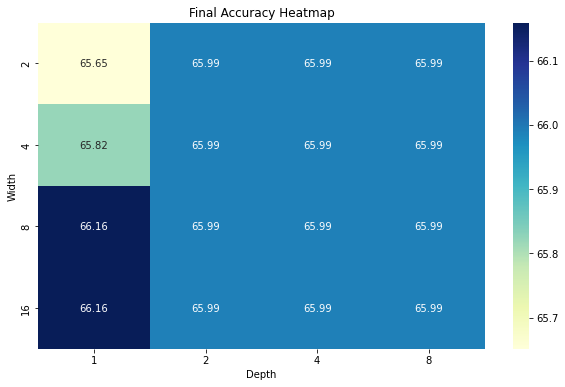

In [18]:

# Define ranges for width and depth
width_range = [2, 4, 8, 16]  # Example widths
depth_range = [1, 2, 4, 8]   # Example depths

# Initialize a 2D array to store accuracies
accuracy_matrix = np.zeros((len(width_range), len(depth_range)))

# Iterate over width and depth
for i, width in enumerate(width_range):
    print(f' -------------------------WIDTH = {width} -------------------------')
    for j, depth in enumerate(depth_range):
        print(f' ------------DEPTH = {depth} -----------')
        net = Net(n_inputs, n_outputs, width, depth)
        
        # Train the model
        acc = TRAIN(net, train_loader, test_loader, weightings, test_dataset, epochs = 20)
        print(acc)
        # Store the final accuracy
        accuracy_matrix[i, j] = acc

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(
    accuracy_matrix,
    annot=True,
    fmt=".2f",
    xticklabels=depth_range,
    yticklabels=width_range,
    cmap="YlGnBu"
)
plt.title("Final Accuracy Heatmap")
plt.xlabel("Depth")
plt.ylabel("Width")
plt.show()
